# Assignment 1
Abrar Rafid Noor

ID: 170204059

Group: B1

In [ ]:
# importing necessary libraries
import numpy as np
import pandas as pd

import skimage
from skimage.io import imread, imshow

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

In [ ]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# reading the upper three rows of the given csv file
df = pd.read_csv('drive/MyDrive/IOT dataset/firmware.csv')
df.head(3)

,filename,class,target,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,...,pixel986,pixel987,pixel988,pixel989,pixel990,pixel991,pixel992,pixel993,pixel994,pixel995,pixel996,pixel997,pixel998,pixel999,pixel1000,pixel1001,pixel1002,pixel1003,pixel1004,pixel1005,pixel1006,pixel1007,pixel1008,pixel1009,pixel1010,pixel1011,pixel1012,pixel1013,pixel1014,pixel1015,pixel1016,pixel1017,pixel1018,pixel1019,pixel1020,pixel1021,pixel1022,pixel1023,pixel1024,Unnamed: 1027
0,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,malware,1,85,17,34,34,0,17,17,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,238,51,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,NaN
1,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,malware,1,85,17,34,34,0,17,17,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,102,34,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,68,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,0,0,0,34,0,0,0,NaN
2,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,malware,1,85,17,34,34,0,17,17,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,238,51,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,NaN


benignware    38073
malware         711
hackware        103
Name: class, dtype: int64

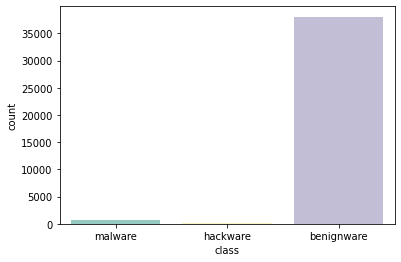

In [ ]:
ax = sns.countplot(x='class', data=df, palette="Set3")
df['class'].value_counts()

All the images from folders *benignware*, *malware* and *hackware* have been put into **images** folder in the drive

In [ ]:
'''SKIP THIS CELL IF THE CSV FILE HAS ALREADY BEEN CREATED'''
# only taking the file names and their classes- whose images are available
X = []
y = []
positions = []

df_new = pd.DataFrame(columns=['filename', 'class'])

pos = -1
for image_name in df['filename']:
  pos += 1
  try: 
    img = imread('drive/MyDrive/cnn_dataset/images/'+image_name+'.jpg')
    X.append(image_name+'.jpg')
    positions.append(pos)
    
  except FileNotFoundError as not_found:
    continue

for i in positions:
  y.append(df['class'][i])

In [ ]:
'''SKIP THIS CELL IF THE CSV FILE HAS ALREADY BEEN CREATED'''
# adding gray image filenames and class in our lists
import os

for filename in os.listdir('drive/MyDrive/cnn_dataset/gray'):
    if filename.endswith("jpg"):  
        X.append(filename)
        y.append('gray')

All the *gray* images have been merged with the rest of the images and these are saved in a new folder named **images_all**

In [ ]:
'''SKIP THIS CELL IF THE CSV FILE HAS ALREADY BEEN CREATED'''
# creating a new dataframe with x and y
df_new = pd.DataFrame(
    {'file_name': X,
     'class_name': y })

In [ ]:
'''SKIP THIS CELL IF THE CSV FILE HAS ALREADY BEEN CREATED'''
df_new['class_name'].value_counts()

benignware    2999
malware        711
gray           669
hackware       103
Name: class_name, dtype: int64

In [ ]:
'''SKIP THIS CELL IF THE CSV FILE HAS ALREADY BEEN CREATED'''
# replacing the labels with numerical values
df_new = df_new.replace('benignware', 0)
df_new = df_new.replace('malware', 1)
df_new = df_new.replace('hackware', 2)
df_new = df_new.replace('gray', 3)
df_new

,file_name,class_name
0,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1
1,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1
2,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1
3,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1
4,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1
...,...,...
4477,lightslategrey.jpg,3
4478,mediumorchid.jpg,3
4479,burlywood3.jpg,3
4480,paleturquoise1.jpg,3


In [ ]:
'''SKIP THIS CELL IF THE CSV FILE HAS ALREADY BEEN CREATED'''
# creating the new csv file
df_new.to_csv('modified_dataset.csv')
!cp modified_dataset.csv "drive/My Drive/cnn_dataset"

In [ ]:
# placing the manual_seed value as my student id
torch.manual_seed(170204059)
np.random.seed(170204059)

In [ ]:
df_new = pd.read_csv('drive/My Drive/cnn_dataset/modified_dataset.csv')
df_new.head(3)

,Unnamed: 0,file_name,class_name
0,0,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1
1,1,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1
2,2,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1


In [ ]:
# removing 'Unnamed: 0' column from our dataframe
df_new = df_new.iloc[:, 1:]
df_new.head(3)

,file_name,class_name
0,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1
1,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1
2,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1


In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4482 entries, 0 to 4481
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   4482 non-null   object
 1   class_name  4482 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 70.2+ KB


In [ ]:
# creating the Dataset class
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L') # L for gray-scale
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
# setting up mean and std for 1 channel images
mean = [0.5,]
std =  [0.5,]

transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

#Instantiate the Dataset Class
dataset  = Dataset(df_new, 'drive/MyDrive/cnn_dataset/images_all.zip (Unzipped Files)/images_all', transform)

print("Total Samples: ", len(dataset))

Total Samples:  4482


In [ ]:
# batch size and test size are set per assignemnt instruction
batch_size = 20
test_size = 0.2

# shuffling the indices of the dataset
indices = list(range(len(dataset)))
np.random.shuffle(indices)

# setting the split position of the dataset
split = int(np.floor(test_size * len(dataset)))
train_index, test_index = indices[split:], indices[:split]

# defining the sampler
train_sampler = SubsetRandomSampler(train_index)
test_sampler = SubsetRandomSampler(test_index)

# preparing the loaders; the dataset is already shuffled 
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size = batch_size, sampler=train_sampler, shuffle=False)

test_loader = torch.utils.data.DataLoader(
    dataset, batch_size = batch_size, sampler=test_sampler, shuffle=False)

print(f"Total train dataloader: {len(train_loader)}")
print(f"Total test dataloader: {len(test_loader)}")

Total train dataloader: 180
Total test dataloader: 45


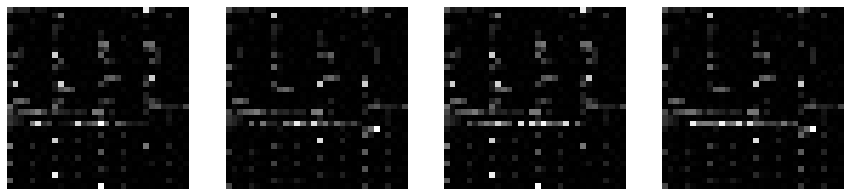

In [ ]:
# the first four images of the dataset
fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(15,15))
for i in range(0,4):
    ax[i].imshow(dataset[i][0].numpy().reshape(32, 32), cmap='gray')
    ax[i].axis('off')

In [ ]:
# defining Hyperparameters
# batch_size has been already defined

num_iters = 2000
input_dim = 32*32 
output_dim = 4
learning_rate = 0.001

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 100) 
        self.layer_2 = nn.Linear(100, 100) 
        self.layer_3 = nn.Linear(100, 100)   
        self.layer_4 = nn.Linear(100, 100)  
        self.layer_5 = nn.Linear(100, 100) 
        self.layer_6 = nn.Linear(100, 4)   
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        

    def forward(self, x):

        x = self.layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)

        x = self.layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)

        x = self.layer_3(x)
        x = self.dropout(x)
        x = self.relu(x)

        x = self.layer_4(x)
        x = self.dropout(x)
        x = self.relu(x)

        x = self.layer_5(x)
        x = self.dropout(x)
        x = self.relu(x)
        
        logits  = self.layer_6(x)
        return logits

In [ ]:
model = NeuralNetwork(input_dim)
model.to(device)

NeuralNetwork(
  (layer_1): Linear(in_features=1024, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=100, bias=True)
  (layer_4): Linear(in_features=100, out_features=100, bias=True)
  (layer_5): Linear(in_features=100, out_features=100, bias=True)
  (layer_6): Linear(in_features=100, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
# optimizers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
import math

# calculating number of epochs
num_epochs = num_iters / (len(train_index) / batch_size)
num_epochs = int(math.ceil(num_epochs))
loss_list = []

n_total_steps = len(train_loader)

iter = 0
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):

    images = images.view(-1, 32*32).to(device)
    labels = labels.to(device)

    # clearing gradients with respect to parameters
    optimizer.zero_grad()

    # forward pass 
    outputs = model(images) 

    # calculating loss
    loss = criterion(outputs, labels)

    # getting gradients with respect to parameters
    loss.backward()

    # updating the parameters
    optimizer.step()      
    
    if (i+1) % 30 == 0:
      print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
      loss_list.append(loss.item())

print('Finished Training')

Epoch [1/12], Step [30/180], Loss: 0.9918
Epoch [1/12], Step [60/180], Loss: 1.0348
Epoch [1/12], Step [90/180], Loss: 0.7672
Epoch [1/12], Step [120/180], Loss: 0.8226
Epoch [1/12], Step [150/180], Loss: 0.9571
Epoch [1/12], Step [180/180], Loss: 0.3033
Epoch [2/12], Step [30/180], Loss: 1.1539
Epoch [2/12], Step [60/180], Loss: 0.8739
Epoch [2/12], Step [90/180], Loss: 0.7785
Epoch [2/12], Step [120/180], Loss: 0.7981
Epoch [2/12], Step [150/180], Loss: 0.4836
Epoch [2/12], Step [180/180], Loss: 0.7548
Epoch [3/12], Step [30/180], Loss: 0.8782
Epoch [3/12], Step [60/180], Loss: 0.5451
Epoch [3/12], Step [90/180], Loss: 0.8123
Epoch [3/12], Step [120/180], Loss: 0.9011
Epoch [3/12], Step [150/180], Loss: 0.6257
Epoch [3/12], Step [180/180], Loss: 0.2379
Epoch [4/12], Step [30/180], Loss: 0.6727
Epoch [4/12], Step [60/180], Loss: 0.6153
Epoch [4/12], Step [90/180], Loss: 1.0046
Epoch [4/12], Step [120/180], Loss: 0.7083
Epoch [4/12], Step [150/180], Loss: 0.6539
Epoch [4/12], Step [180

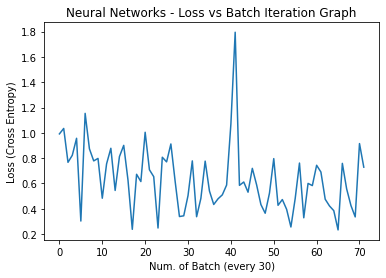

In [ ]:
# plotting the loss per batch graph
plt.plot(loss_list)

plt.xlabel('Num. of Batch (every 30)')
plt.ylabel('Loss (Cross Entropy)')
 
plt.title('Neural Networks - Loss vs Batch Iteration Graph')
 
plt.show()

In [ ]:
with torch.no_grad():
  n_correct = 0
  n_incorrect = 0
  n_samples = 0
  n_class_correct = [0 for i in range(4)]
  n_class_incorrect = [0 for i in range(4)]
  n_class_predicted = [0 for i in range(4)]
  n_class_samples = [0 for i in range(4)]


  for images, labels in test_loader:
    images = images.view(-1, 32*32).to(device)
    labels = labels.to(device)
    outputs = model(images)
    # max returns (value ,index)
    _, predicted = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()
    n_incorrect += (predicted != labels).sum().item()
    
    for i in range(len(labels)):
      label = labels[i]
      pred = predicted[i]
      if (label == pred):
        n_class_correct[label] += 1
      else:
        n_class_incorrect[label] += 1
      n_class_predicted[pred] += 1  
      n_class_samples[label] += 1

  print('Testing Completed!')

Testing Completed!


In [ ]:
n_class_samples

[595, 144, 23, 134]

In [ ]:
n_class_correct 

[592, 0, 0, 130]

In [ ]:
n_class_predicted

[763, 0, 0, 133]

In [ ]:
classes = ['benignware', 'malware', 'hackware', 'gray']
total_pre = []
total_rec = []

for i in range(4):
  try:
    pre = n_class_correct[i] / n_class_predicted[i]
  except ZeroDivisionError:
    pre = 0
  total_pre.append(pre)
  try:
    rec = n_class_correct[i] / n_class_samples[i] 
  except ZeroDivisionError:
    rec = 0
  total_rec.append(rec) 
  '''
  try:
    f1 = ((2*total_pre.sum()*total_rec.sum())/(total_pre.sum()+total_rec.sum()))/4
  except ZeroDivisionError:
    f1 = 'undefined'
  '''
  f1 = (2*sum(total_pre)*sum(total_rec))/(sum(total_pre)+sum(total_rec))/4
print(f'F-1 Score: {f1}')

F-1 Score: 0.46329673738675287


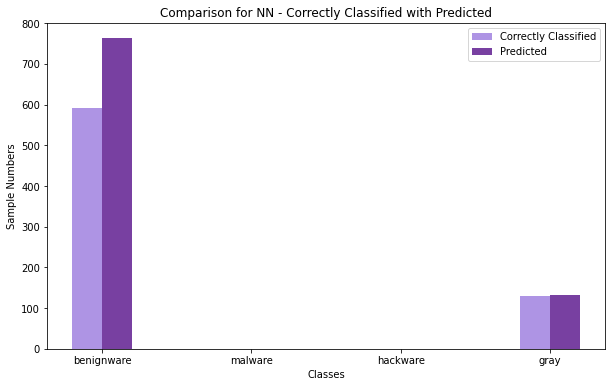

In [ ]:
index = np.arange(0, 4)
width = 0.2
plt.figure(figsize = (10, 6))
plt.title('Comparison for NN - Correctly Classified with Predicted')

plt.bar(index , n_class_correct, width, color='mediumpurple', label='Correctly Classified', alpha=0.75)
plt.bar(index + width, n_class_predicted, width, color='indigo', label='Predicted', alpha=0.75)
  
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(index+width/2, classes)
plt.legend()
plt.show()

In [ ]:
class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3) #in_channels, out_channels, filter (3X3)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 30, 3)
        self.fc1 = nn.Linear(30 * 2 * 2, 60)
        self.fc2 = nn.Linear(60, 30)
        self.fc3 = nn.Linear(30, 15)
        self.fc4 = nn.Linear(15, 4)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()


    def forward(self, x):       #input, channel, width, height 
                                # -> n, 1, 32, 32               
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)                       
                                # -> n, 6, 15, 15
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)                       
                                # -> n, 16, 6, 6
        x = self.conv3(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x) 
                                # -> n, 30, 2, 2 
        x = x.view(-1, 30*2*2)              
                                # -> n, 120 
        x = self.fc1(x)
        x = self.relu(x)                         
                                # -> n, 60 
        x = self.fc2(x)
        x = self.relu(x)                         
                                # -> n, 30
        x = self.fc3(x)         
        x = self.relu(x)
                                # -> n, 15
        x = self.fc4(x)                         
                                # -> n, 4
                                              
        return x

In [ ]:
model = ConvNet1()
model.to(device)

ConvNet1(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 30, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=15, bias=True)
  (fc4): Linear(in_features=15, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
import math

# calculating number of epochs
num_epochs = num_iters / (len(train_index) / batch_size)
num_epochs = int(math.ceil(num_epochs))
loss_list = []

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 30 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            loss_list.append(loss.item())
print('Finished Training')

Epoch [1/12], Step [30/180], Loss: 0.7265
Epoch [1/12], Step [60/180], Loss: 0.7321
Epoch [1/12], Step [90/180], Loss: 0.4515
Epoch [1/12], Step [120/180], Loss: 0.3121
Epoch [1/12], Step [150/180], Loss: 0.9296
Epoch [1/12], Step [180/180], Loss: 0.6642
Epoch [2/12], Step [30/180], Loss: 0.3251
Epoch [2/12], Step [60/180], Loss: 0.5835
Epoch [2/12], Step [90/180], Loss: 0.5207
Epoch [2/12], Step [120/180], Loss: 0.4848
Epoch [2/12], Step [150/180], Loss: 0.3840
Epoch [2/12], Step [180/180], Loss: 0.7034
Epoch [3/12], Step [30/180], Loss: 0.3918
Epoch [3/12], Step [60/180], Loss: 0.3921
Epoch [3/12], Step [90/180], Loss: 0.3212
Epoch [3/12], Step [120/180], Loss: 0.6146
Epoch [3/12], Step [150/180], Loss: 0.4761
Epoch [3/12], Step [180/180], Loss: 0.2585
Epoch [4/12], Step [30/180], Loss: 0.4928
Epoch [4/12], Step [60/180], Loss: 0.6848
Epoch [4/12], Step [90/180], Loss: 0.7008
Epoch [4/12], Step [120/180], Loss: 0.5589
Epoch [4/12], Step [150/180], Loss: 0.5870
Epoch [4/12], Step [180

In [ ]:
with torch.no_grad():
  n_correct = 0
  n_incorrect = 0
  n_samples = 0
  n_class_correct = [0 for i in range(4)]
  n_class_incorrect = [0 for i in range(4)]
  n_class_predicted = [0 for i in range(4)]
  n_class_samples = [0 for i in range(4)]


  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    # max returns (value ,index)
    _, predicted = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()
    n_incorrect += (predicted != labels).sum().item()
    
    for i in range(len(labels)):
      label = labels[i]
      pred = predicted[i]
      if (label == pred):
        n_class_correct[label] += 1
      else:
        n_class_incorrect[label] += 1
      n_class_predicted[pred] += 1  
      n_class_samples[label] += 1

  print('Testing Completed!')

Testing Completed!


In [ ]:
n_class_samples

[595, 144, 23, 134]

In [ ]:
n_class_correct

[579, 31, 0, 134]

In [ ]:
n_class_predicted

[708, 54, 0, 134]

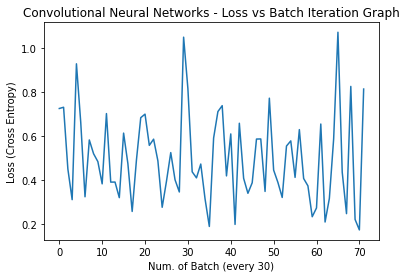

In [ ]:
# plotting the loss per batch graph

plt.plot(loss_list)

plt.xlabel('Num. of Batch (every 30)')
plt.ylabel('Loss (Cross Entropy)')
 
plt.title('Convolutional Neural Networks - Loss vs Batch Iteration Graph')
 
plt.show()

In [ ]:
classes = ['benignware', 'malware', 'hackware', 'gray']
total_pre = []
total_rec = []

for i in range(4):
  try:
    pre = n_class_correct[i] / n_class_predicted[i]
  except ZeroDivisionError:
    pre = 0
  total_pre.append(pre)
  try:
    rec = n_class_correct[i] / n_class_samples[i]
  except ZeroDivisionError:
    rec = 0
  total_rec.append(rec) 
  '''
  try:
    f1 = ((2*total_pre.sum()*total_rec.sum())/(total_pre.sum()+total_rec.sum()))/4
  except ZeroDivisionError:
    f1 = 'undefined'
  '''
  f1 = (2*sum(total_pre)*sum(total_rec))/(sum(total_pre)+sum(total_rec))/4
print(f'F-1 Score: {f1}')

F-1 Score: 0.5714022112675303


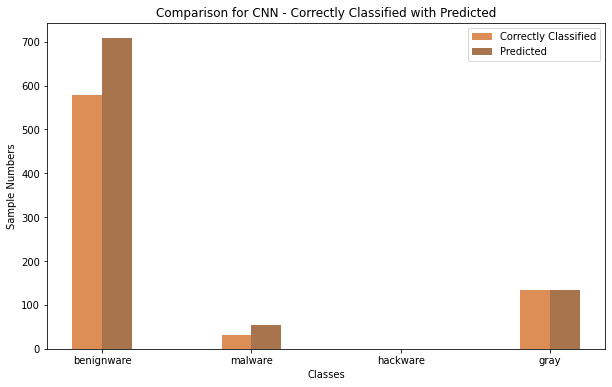

In [ ]:
index = np.arange(0, 4)
width = 0.2
plt.figure(figsize = (10, 6))
plt.title('Comparison for CNN - Correctly Classified with Predicted')

plt.bar(index , n_class_correct, width, color='chocolate', label='Correctly Classified', alpha=0.75)
plt.bar(index + width, n_class_predicted, width, color='saddlebrown', label='Predicted', alpha=0.75)
  
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(index+width/2, classes)
plt.legend()
plt.show()

In [ ]:
# following LeNet-5
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) #in_channels, out_channels, filter (5X5)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()


    def forward(self, x):
                                # -> n, 1, 32, 32               
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)                       
                                # -> n, 6, 14, 14
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)                       
                                # -> n, 16, 5, 5
        x = x.view(-1, 16*5*5)  # -> n, 400             
        
        x = self.fc1(x)
        x = self.relu(x)                         
                                # -> n, 120 
        x = self.fc2(x)
        x = self.relu(x)                         
                                # -> n, 84
        x = self.fc3(x)         
                                # -> n, 4              
        return x


In [ ]:
model = ConvNet2()
model.to(device)

ConvNet2(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
import math

# calculating number of epochs
num_epochs = num_iters / (len(train_index) / batch_size)
num_epochs = int(math.ceil(num_epochs))
loss_list = []

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 30 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            loss_list.append(loss.item())
print('Finished Training')

Epoch [1/12], Step [30/180], Loss: 0.6005
Epoch [1/12], Step [60/180], Loss: 0.7385
Epoch [1/12], Step [90/180], Loss: 0.5446
Epoch [1/12], Step [120/180], Loss: 0.3597
Epoch [1/12], Step [150/180], Loss: 0.7908
Epoch [1/12], Step [180/180], Loss: 0.5107
Epoch [2/12], Step [30/180], Loss: 0.7048
Epoch [2/12], Step [60/180], Loss: 0.5832
Epoch [2/12], Step [90/180], Loss: 0.4032
Epoch [2/12], Step [120/180], Loss: 0.8960
Epoch [2/12], Step [150/180], Loss: 0.6230
Epoch [2/12], Step [180/180], Loss: 0.6176
Epoch [3/12], Step [30/180], Loss: 0.5442
Epoch [3/12], Step [60/180], Loss: 0.3363
Epoch [3/12], Step [90/180], Loss: 0.3737
Epoch [3/12], Step [120/180], Loss: 0.4001
Epoch [3/12], Step [150/180], Loss: 1.0675
Epoch [3/12], Step [180/180], Loss: 0.2548
Epoch [4/12], Step [30/180], Loss: 0.7629
Epoch [4/12], Step [60/180], Loss: 0.8362
Epoch [4/12], Step [90/180], Loss: 0.2377
Epoch [4/12], Step [120/180], Loss: 0.3535
Epoch [4/12], Step [150/180], Loss: 0.3545
Epoch [4/12], Step [180

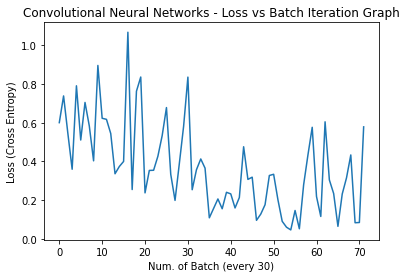

In [ ]:
# plotting the loss per batch graph
plt.plot(loss_list)

plt.xlabel('Num. of Batch (every 30)')
plt.ylabel('Loss (Cross Entropy)')
 
plt.title('Convolutional Neural Networks - Loss vs Batch Iteration Graph')
 
plt.show()

In [ ]:
with torch.no_grad():
  n_correct = 0
  n_incorrect = 0
  n_samples = 0
  n_class_correct = [0 for i in range(4)]
  n_class_incorrect = [0 for i in range(4)]
  n_class_predicted = [0 for i in range(4)]
  n_class_samples = [0 for i in range(4)]


  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    # max returns (value ,index)
    _, predicted = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()
    n_incorrect += (predicted != labels).sum().item()
    
    for i in range(len(labels)):
      label = labels[i]
      pred = predicted[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_predicted[pred] += 1  
      n_class_samples[label] += 1

  acc = 100.0 * n_correct / n_samples
  print('Testing Completed')

Testing Completed


In [ ]:
n_class_samples

[595, 144, 23, 134]

In [ ]:
n_class_correct

[578, 107, 15, 134]

In [ ]:
n_class_predicted

[623, 122, 17, 134]

In [ ]:
classes = ['benignware', 'malware', 'hackware', 'gray']
total_pre = []
total_rec = []

for i in range(4):
  try:
    pre = n_class_correct[i] / n_class_predicted[i]
  except ZeroDivisionError:
    pre = 0
  total_pre.append(pre)
  try:
    rec = n_class_correct[i] / n_class_samples[i]
  except ZeroDivisionError:
    rec = 0
  total_rec.append(rec) 
  '''
  try:
    f1 = ((2*total_pre.sum()*total_rec.sum())/(total_pre.sum()+total_rec.sum()))/4
  except ZeroDivisionError:
    f1 = 'undefined'
  '''
  f1 = (2*sum(total_pre)*sum(total_rec))/(sum(total_pre)+sum(total_rec))/4
print(f'F-1 Score: {f1}')

F-1 Score: 0.879908188340915


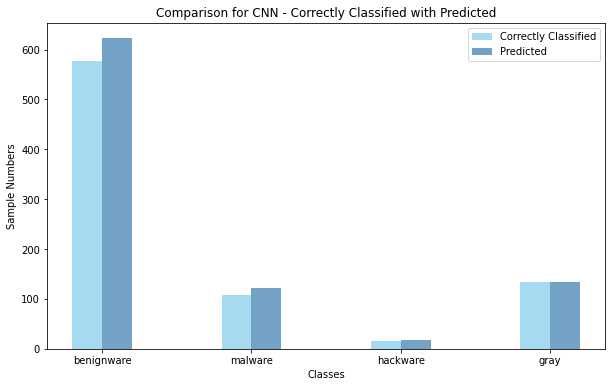

In [ ]:
index = np.arange(0, 4)
width = 0.2
plt.figure(figsize = (10, 6))
plt.title('Comparison for CNN - Correctly Classified with Predicted')

plt.bar(index , n_class_correct, width, color='skyblue', label='Correctly Classified', alpha=0.75)
plt.bar(index + width, n_class_predicted, width, color='steelblue', label='Predicted', alpha=0.75)
  
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(index+width/2, classes)
plt.legend()
plt.show()